In [13]:
!kaggle competitions download -c invasive-species-monitoring -p /storage/invasive-species/

invasive-species-monitoring.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
import os
from fastai.vision.all import *
from fastai.losses import BCEWithLogitsLossFlat


path = Path("/storage/invasive-species/invasive-species-data/")
os.listdir(path)

['train',
 'invasive-species-monitoring.zip',
 'test.7z',
 'sample_submission.csv.zip',
 'sample_submission.csv',
 'tabular-playground-series-apr-2021.zip',
 'train.7z',
 'train_labels.csv.zip',
 'test',
 '__MACOSX',
 'train_labels.csv']

In [2]:
df = pd.read_csv(path/'train_labels.csv')
df.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [3]:
dblock = DataBlock()

In [4]:
dsets = dblock.datasets(df)

In [5]:
len(dsets.train),len(dsets.valid)

(1836, 459)

In [6]:
df

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1
...,...,...
2290,2291,1
2291,2292,1
2292,2293,1
2293,2294,1


In [7]:
def get_x(r): return path/'train'/str(str(r['name'])+'.jpg')
def get_y(r): return r['invasive']

def get_dls(x, bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                splitter=RandomSplitter(seed=42),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(df, bs=bs)

In [8]:
dls = get_dls(df, 64, 224)
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.3752,  0.0299, -0.2265], device='cuda:0'),
 TensorImage([0.9770, 1.0599, 1.0382], device='cuda:0'))

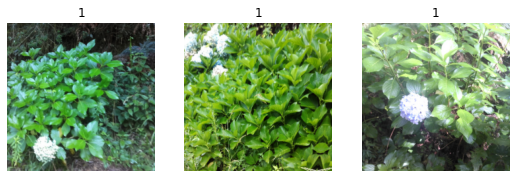

In [9]:
dls.show_batch(nrows=1, ncols=3)

In [10]:
dls = get_dls(df, 64, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.486544,1.515149,0.562092,00:30
1,0.498586,0.995422,0.714597,00:19
2,0.413046,0.556877,0.753813,00:19
3,0.347625,1.761927,0.736383,00:19
4,0.299146,0.278132,0.875817,00:19
5,0.269957,0.465553,0.814815,00:18
6,0.250053,0.202549,0.919390,00:19
7,0.216308,0.183706,0.921569,00:19
8,0.193473,0.194363,0.917211,00:18
9,0.173959,0.186157,0.921569,00:19


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

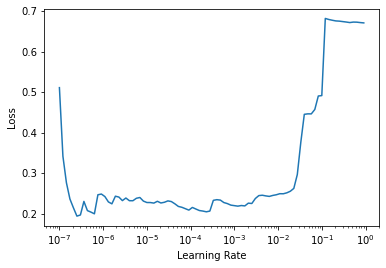

In [12]:
learn.dls = get_dls(df, 32, 224)
learn.lr_find()

In [13]:
learn.dls = get_dls(df, 32, 224)
learn.fine_tune(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.200685,0.267410,0.899782,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.164994,0.233520,0.910675,00:32
1,0.154125,0.218086,0.919390,00:32
2,0.161578,0.209316,0.919390,00:32
3,0.156755,0.199213,0.925926,00:32
4,0.154946,0.189883,0.928105,00:32
5,0.145910,0.184642,0.925926,00:32
6,0.141143,0.175358,0.930283,00:32
7,0.136983,0.178541,0.932462,00:32
8,0.136399,0.160117,0.936819,00:32
9,0.127788,0.158690,0.934641,00:32


In [14]:
import kaggle

In [15]:
df_s = pd.read_csv(path/'sample_submission.csv')
df_s.head()

,name,invasive
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [25]:
%%capture
preds = []
for i in df_s['name'].iteritems():
    x = load_image(path/'test'/str(str(i[1])+'.jpg'))
    preds.append(learn.predict(PILImage(x))[0])

In [26]:
df_s['invasive'] = preds

In [27]:
df_s = df_s.set_index('name')
df_s.to_csv('submission.csv')

In [28]:
kaggle.api.competition_submit('submission.csv','fastai submission','invasive-species-monitoring')

100%|██████████| 9.40k/9.40k [00:00<00:00, 23.7kB/s]


Successfully submitted to Invasive Species Monitoring